## Preparing

In [ ]:
!git init .
!git remote add -f origin "https://github.com/Sankek/ImageInpainting"
!git pull origin master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 91 (delta 45), reused 58 (delta 20), pack-reused 0
Unpacking objects: 100% (91/91), done.
From https://github.com/Sankek/ImageInpainting
 * [new branch]      master     -> origin/master
From https://github.com/Sankek/ImageInpainting
 * branch            master     -> FETCH_HEAD


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping archive with ~50% of open ImageNet images 
!unzip "/content/drive/MyDrive/Projects/ImageInpainting/dataset/train_part2.zip" > /dev/null
!mv train_part2 train_set

In [ ]:
# Since Google Colab removed the ability to connect to Google Drive from 
# a non-current account, there is some hack that still allows you to do this.
#
# You need to follow the link that will appear in the output and login to the 
# account that owns the desired Google Drive.
#
# After that, you need to run the next cell.
#
# https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab/70797774#70797774

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
%cd /content

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libgpm2:amd64.
(Reading database ... 155658 files and directories currently installed.)
Preparing to unpack .../libgpm2_1.20.7-5_amd64.deb ...
Unpacking libgpm2:amd64 (1.20.7-5) ...
Selecting previously unselected package w3m.
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up libgpm2:amd64 (1.20.7-5) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/

## Go

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from data import InpaintingDataset
from model import PConvUNet, PConvUNet_v2, VGG16FE, DiscriminatorNet
from losses import InpaintingAdversarialLoss, DiscriminatorLoss
from utils import save_state, load_state, get_from_state, tensor2image, smooth1d
from train import train

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Sat Jul 23 10:59:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 12

dataset_mean = [0.485, 0.456, 0.406] 
dataset_std = [0.229, 0.224, 0.225]

dataset = InpaintingDataset('train_set', 256, dataset_mean=dataset_mean, dataset_std=dataset_std)
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

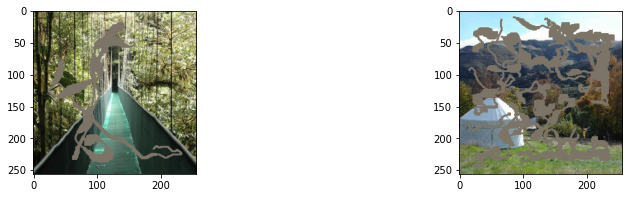

In [ ]:
def plot_examples():
    fig, axs = plt.subplots(1, 2, figsize=(14, 3))
    inp, mask, target = next(iter(dataloader))
    for i in range(2):
        axs[i].imshow(tensor2image(inp[i], dataset_mean, dataset_std))
    plt.show()
plot_examples()

In [ ]:
lr = 2e-4
discriminator_lr = 1e-4

trained_iters=0
save_folder = '/content/drive/MyDrive/Projects/ImageInpainting/saved'

# model = PConvUNet_v2().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

prev_state = load_state(save_folder, 'v2_finetune_lr_1e-5_2450004')
model, optimizer = get_from_state(prev_state)


discriminator = DiscriminatorNet().to(DEVICE)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr)

# discriminator_prev_state = load_state(save_folder, 'D_')
# discriminator, discriminator_optimizer = get_from_state(discriminator_prev_state)


feature_extractor = VGG16FE().to(DEVICE)
criterion = InpaintingAdversarialLoss(feature_extractor)
discriminator_criterion = DiscriminatorLoss()

save_name ='v2_finetune_adversarial'
# trained_iters = prev_state['trained_iters']
trained_iters=0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Training

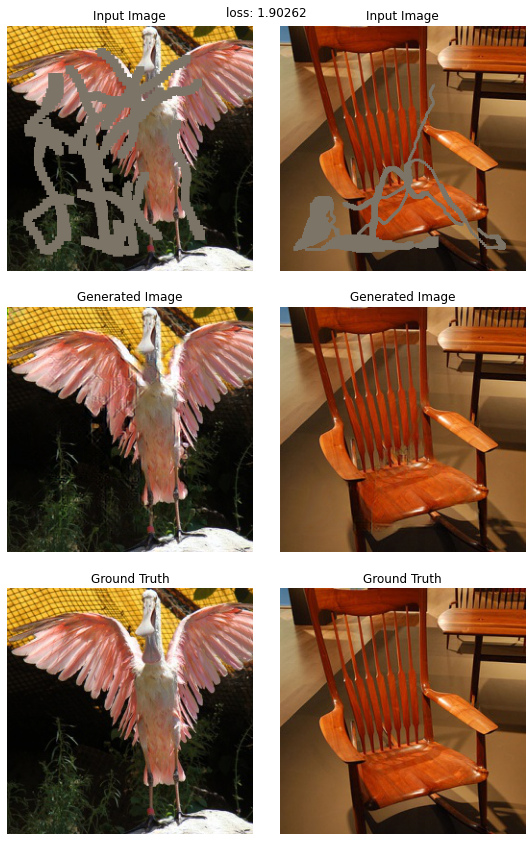

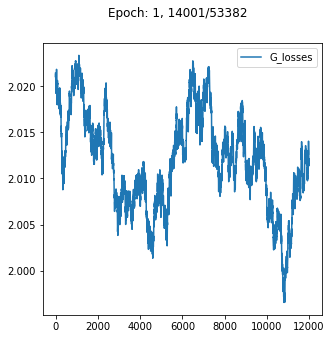

In [ ]:
train(
    model, optimizer, discriminator, discriminator_optimizer, dataloader, criterion, 
    discriminator_criterion, dataset_mean, dataset_std, 
    epochs=1, device=DEVICE, trained_iters=trained_iters, save_folder=save_folder, 
    save_name=save_name, losses_smooth_window=2000, graph_show_interval=500
)